In [19]:
# 05 — SHAP Explainability + Governance Notes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap

df = pd.read_csv("creditcard.csv")
cols = list(df.columns)

label_col = "Class" if "Class" in cols else "class"
df[label_col] = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype(int)

X = df.drop(columns=[label_col])
y = df[label_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / max(pos, 1)

# Compact model for SHAP (speed)
model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    random_state=42
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, ...)

In [21]:
# Sample for SHAP: keep all fraud + manageable non-fraud sample
fraud_idx = y_test[y_test == 1].index
nonfraud_idx = y_test[y_test == 0].sample(
    n=min(5000, int((y_test == 0).sum())),
    random_state=42
).index
sample_idx = fraud_idx.union(nonfraud_idx)

X_sample = X_test.loc[sample_idx]
print("SHAP sample shape:", X_sample.shape)

SHAP sample shape: (5098, 30)


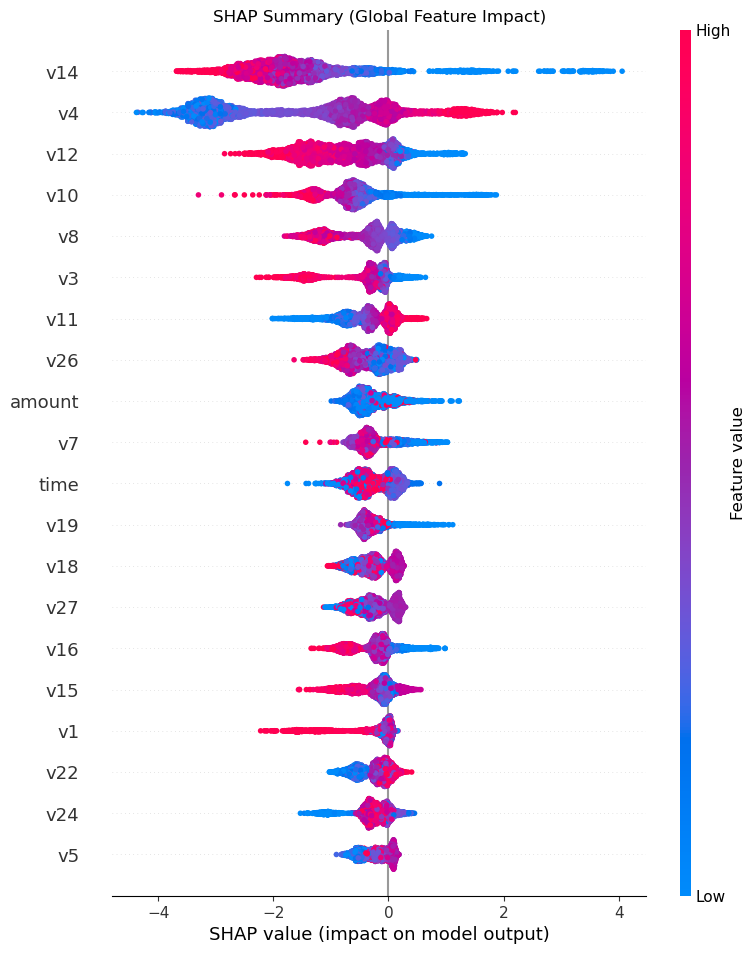

In [23]:
# SHAP values + global plot
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Summary (Global Feature Impact)")
plt.show()

In [25]:
# Top 10 features by mean(|SHAP|)
mean_abs = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(mean_abs)[::-1][:10]

top = pd.DataFrame({
    "feature": X_sample.columns[top_idx],
    "mean_abs_shap": mean_abs[top_idx]
})
top

,feature,mean_abs_shap
0,v14,1.741261
1,v4,1.638836
2,v12,0.845421
3,v10,0.726088
4,v8,0.518651
5,v3,0.444060
6,v11,0.426577
7,v26,0.418618
8,amount,0.374629
9,v7,0.363232


In [27]:
print("""
Interpretability limitations (important):
- Features V1–V28 are PCA components → no direct human business semantics.
- SHAP is used to understand which latent components drive risk scores
  and to support monitoring/audit, not to explain transactions to customers.

Governance & Monitoring:
- Track fraud rate + label drift
- Track score distribution shift
- Monitor precision at fixed review capacity (e.g., top 0.5% flagged)
- Monitor FP rate / customer friction
- Retrain on a rolling window or when drift triggers
- Keep human-in-the-loop for investigation and compliance
""")


Interpretability limitations (important):
- Features V1–V28 are PCA components → no direct human business semantics.
- SHAP is used to understand which latent components drive risk scores
  and to support monitoring/audit, not to explain transactions to customers.

Governance & Monitoring:
- Track fraud rate + label drift
- Track score distribution shift
- Monitor precision at fixed review capacity (e.g., top 0.5% flagged)
- Monitor FP rate / customer friction
- Retrain on a rolling window or when drift triggers
- Keep human-in-the-loop for investigation and compliance

